<a href="https://colab.research.google.com/github/Astromax/Retina_Disease_Classification/blob/main/EyeDiseaseDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The purpose of this is to determine whether or not a retina is healthy, and, if not, which of six different diseases it has. The data for this comes from a Kaggle competition, https://www.kaggle.com/c/vietai-advance-course-retinal-disease-detection/overview.
 There are 3,435 training images, with the following label breakdown: opacity - 0, diabetic retinopathy - 1, glaucoma - 2, macular edema - 3, macular degeneration - 4, retinal vascular occlusion - 5, and normal - 6.
An important note: unlike an ordinary classification problem, in this case a retina may be afflicted with more than one ailment.  Because of this, the activation function for the final layer is sigmoid, instead of the usual softmax, effectively providing a probability for each label independent of the others.

The data has been uploaded to my Google Drive for easy access & processing, if anyone reading this wants to replicate it just change the target directories.

In [1]:
#First let's mount the Drive so we can access the data...
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/EyeDiseaseDetection/')
MAIN_DIR = '/content/drive/MyDrive/EyeDiseaseDetection'

In [3]:
#from resnet_module_helpers_tf import *
from eye_DD_metrics_helpers import *
from training_plot_helpers import *

# Display
from IPython.display import Image, display

import json

import matplotlib.cm as colormap
import matplotlib.pyplot as plt

import numpy as np

import pandas as pd
from PIL import Image, ImageDraw
from plotly.subplots import make_subplots

import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix as MLCM
from sklearn.model_selection import train_test_split
import tensorflow as tf

from keras.activations import relu, swish
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, MaxPool2D, Dense, Dropout, Input, BatchNormalization, Activation
from tensorflow.keras.layers.experimental.preprocessing import RandomCrop, RandomFlip, RandomRotation

import time
from tqdm import tqdm

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
#Establish location of data
data_dir = './Data/Data/train'
image_dir = data_dir+'/train'

In [5]:
filenames = os.listdir(image_dir)
print(f'Number of files: {len(filenames)}')
#print('Number of files: ', len(filenames))

Number of files: 3435


## Exploratory Data Analysis

Before doing the heavy-duty analysis, let's first make sure there are no anomalies.  A retina can have multiple diseases simultaneously, which means this is not a simple image classification problem.  However, there is also a seventh label, 'Normal', corresponding to a healthy retina.  If a retina has a disease it is, by definition, unhealthy, therefore any images with a one in the 'Normal' column *and any other* is an anomaly, which should be excluded from the analysis.  Similarly, an image with all zeros, corresponding to either a mislabel or a retina with a disease not in this set, is not useful for this analysis.

In [6]:
labels_df = pd.read_csv(data_dir+'/train.csv')

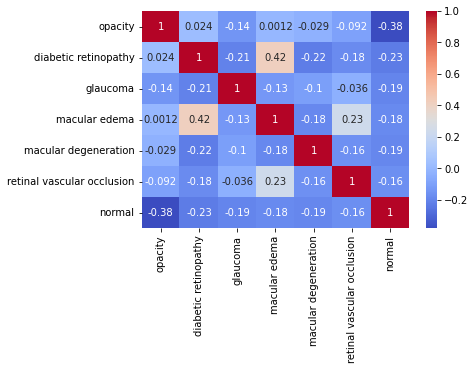

In [7]:
#Let's get the correlations between all pairs of columns and plot them as a heatmap
fig = sns.heatmap(labels_df.corr(), annot=True, fmt='0.2g', cmap='coolwarm')
#sns.set(rc={'figure.figsize':(15,20)})
fig.figure.savefig(f'{MAIN_DIR}/Disease_Correlations.png')

We see there is some correlation between diabetic retinopathy and macular edema, and a more mild correlation between macular edema and retinal vascular occlusion.  Normality is anti-correlated with all other labels, which is to be expected, although the magnitude is not as great as I would have expected.  Diabetic retinopathy is anti-correlated with glaucoma and macular degeneration.  More domain knowledge is necessary to interpret these (anti)correlations, but they are interesting nonetheless.

To streamline the process of entering in the labels for training, we first create a new column consolidating the entries in the seven main columns into a column of 7-tuples.  This is the "y" that the model is learning from and trying to predict.

In [8]:
#Convert the individual label values to int type, add in a multi-hot vector label
MH = list(zip(labels_df['opacity'], labels_df['diabetic retinopathy'], labels_df['glaucoma'], labels_df['macular edema'],
                                  labels_df['macular degeneration'], labels_df['retinal vascular occlusion'], labels_df['normal']))
labels_df['Multi_Hot'] = MH

In [9]:
y = labels_df['Multi_Hot']
y = np.array([y.iloc[i] for i in range(len(y))])
print(f'Length of y: {len(y)}')

Length of y: 3435


In [10]:
#More efficient anomaly check
blanks = [p for p in y if sum(p) == 0]
print(f'Number of Blanks: {len(blanks)}')

anomalies = [p for p in y if p[-1] == 1 and sum(p[:-1]) > 0]
print(f'Number of Anomalies: {len(anomalies)}')

Number of Blanks: 0
Number of Anomalies: 0


In [14]:
# Copied & modified from: https://www.geeksforgeeks.org/adding-value-labels-on-a-matplotlib-bar-chart/
def addlabels(x,y):
    for idx,_ in enumerate(x):
        plt.text(idx, y[idx], y[idx], ha = 'center',
                 Bbox = dict(facecolor = 'red', alpha =.8))

Number of Totals: 2910


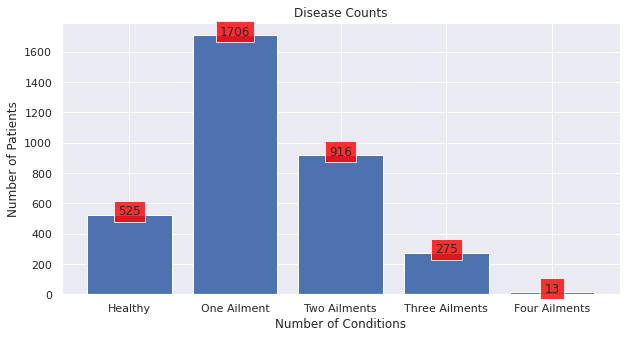

In [15]:
#Let's see how many patients have one vs two vs ... ailments
totals = [sum(p) for idx,p in enumerate(y) if p[-1] != 1]
print(f'Number of Totals: {len(totals)}')

hs  = [p for p in y if p[-1] == 1]
p1s = [p for p in totals if p == 1]
p2s = [p for p in totals if p == 2]
p3s = [p for p in totals if p == 3]
p4s = [p for p in totals if p == 4]

x = ['Healthy', 'One Ailment', 'Two Ailments', 'Three Ailments', 'Four Ailments']
z = [len(hs), len(p1s), len(p2s), len(p3s), len(p4s)]

fname = f'{MAIN_DIR}/Disease_Counts.jpg'
plt.figure(figsize=(10,5))
plt.bar(x, z)
addlabels(x, z)
plt.title('Disease Counts')
plt.xlabel('Number of Conditions')
plt.ylabel('Number of Patients')
plt.savefig(fname)
plt.show()

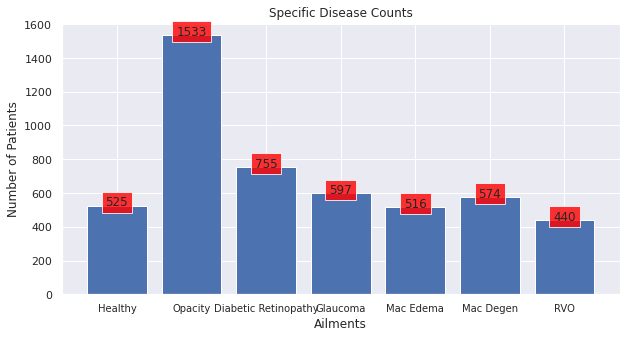

In [23]:
#Plot the individual number of occurrences for each ailment

hs  = [p for p in y if p[-1] == 1]
p_opa = [p for p in y if p[0] == 1]
p_dr = [p for p in y if p[1] == 1]
p_gla = [p for p in y if p[2] == 1]
p_me = [p for p in y if p[3] == 1]
p_md = [p for p in y if p[4] == 1]
p_rvo = [p for p in y if p[5] == 1]

x = ['Healthy', 'Opacity', 'Diabetic Retinopathy', 'Glaucoma', 'Mac Edema', 'Mac Degen', 'RVO']
z = [len(hs), len(p_opa), len(p_dr), len(p_gla), len(p_me), len(p_md), len(p_rvo)]

fname = f'{MAIN_DIR}/Individual_Disease_Counts.jpg'
plt.figure(figsize=(10,5))
plt.bar(x, z)
addlabels(x, z)
plt.title('Specific Disease Counts')
plt.xlabel('Ailments')
plt.ylabel('Number of Patients')
plt.xticks(fontsize=10)
plt.savefig(fname)
plt.show()

Here we load in the full set of images.  tqdm produces the progress bar and is not strictly necessary, but with this many images it can be nice to know how much longer to expect.  Google Colab has quite a bit of variability, in some experiments it loaded the full dataset in under 10 minutes, while other times it took more than half an hour.

In [11]:
train_images = []
for i in tqdm(range(labels_df.shape[0])):
    img = image.load_img(image_dir+'/'+ labels_df['filename'][i], target_size=(224,224,3), grayscale=False)
    img = image.img_to_array(img)
    img = img/255
    train_images.append(img)

X = np.array(train_images)


100%|██████████| 3435/3435 [08:45<00:00,  6.54it/s]


In [12]:
#Perform the train_test split.  Fix random_state for reproducibility
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=37, test_size=0.3)
print(f'Length of X_train: {len(X_train)}')
print(f'Length of X_val: {len(X_val)}')

Length of X_train: 2404
Length of X_val: 1031


## Utility Functions
Once fully tested, the various utility functions will be written out to a "Utilities.py" module & imported at the top to keep things clean.
The first utility function is write_json.  For reproducibility, we want to write all the hyperparameters to a JSON file to keep track of everything.

In [13]:
# function to add to JSON, modified from the Geeks for Geeks article
# https://www.geeksforgeeks.org/append-to-json-file-using-python/
def write_json(new_data: dict, filename: str='RDC_experiments.json') -> None:
    if not os.path.exists(filename):
        print('initializing JSON file')
        with open(filename,'w') as jsonFile:
            nd = {'exp_details': [new_data]}
            json.dump(nd, jsonFile)
        return
    with open(filename,'r+') as file:
        print('updating JSON file')
          # First we load existing data into a dict.
        file_data = json.load(file)
        # Join new_data with file_data inside exp_details
        file_data['exp_details'].append(new_data)
        # Sets file's current position at offset.
        file.seek(0)
        # convert back to json.
        json.dump(file_data, file, indent = 4)

Plotting functions for evaluating training progression.

In [14]:
def print_loss_history(training_history, modelname: str, expnum: int) -> None:
    loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, color='red', label='Training loss')
    plt.plot(epochs, val_loss, color='green', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f'{MAIN_DIR}/{modelname}_Training_and_Validation_loss_ExpNum_{expnum}.jpg')
    plt.show()
    return


def print_training_history(training_history, metrics: list, modelname: str, expnum: int) -> None:
    for met in metrics:
        if met not in training_history.history:
            print(f'Error: {met} missing from history!  Add it to the metrics in the compile step.')
            continue
        trainmet = training_history.history[met]
        valmet = training_history.history[f'val_{met}']
        epochs = range(1, len(trainmet) + 1)
        plt.plot(epochs, trainmet, color='red', label=f'Training {met}')
        plt.plot(epochs, valmet, color='green', label=f'Validation {met}')
        plt.title(f'Training and Validation {met}')
        plt.xlabel('Epochs')
        plt.ylabel(met)
        plt.legend()
        plt.savefig(f'{modelname}_Training_and_Validation_{met}_ExpNum_{expnum}.jpg')
        plt.show()
    return

Some experiments have found that batch sizes larger than 32 do not improve performance: https://arxiv.org/pdf/1804.07612.pdf

In [15]:
#Model Name
modelname = 'Model_One'

#Experiment Number
expno = 3

# Hyperparameters -- keep them all here for easy organization
BATCH_SIZE = 16            #Batch size
EPOCHS = 25                #Number of epochs to train for
EPS_SAFETY = 1e-8          #Safety parameter

#Data augmentation
CHANNEL_SHIFT_RANGE = 0.05 #Allowed range of channel shifting 
HEIGHT_SHIFT_RANGE = 0.25  #Allowed range of height shift 
ROTATION_RANGE = 45        #Allowed range of rotations 
WIDTH_SHIFT_RANGE = 0.25   #Allowed range of width shift 
ZOOM_RANGE = 0.2           #Allowed range of zoom 

# Learning Rate & Scheduler
IRL = 1e-4           #Initial learning rate
DRATE = 0.9          #Decay rate
DSTEPS = 10000       #Decay steps

In [16]:
hypers = {'BATCH_SIZE': BATCH_SIZE, 'CHANNEL_SHIFT_RANGE': CHANNEL_SHIFT_RANGE, 'DRATE': DRATE, 'DSTEPS': DSTEPS,'EPOCHS': EPOCHS, 
          'EPS_SAFETY': EPS_SAFETY, 'HEIGHT_SHIFT_RANGE': HEIGHT_SHIFT_RANGE, 'IRL': IRL, 'ROTATION_RANGE': ROTATION_RANGE, 
          'WIDTH_SHIFT_RANGE': WIDTH_SHIFT_RANGE, 'ZOOM_RANGE': ZOOM_RANGE}

We will want to augment the training set. For these images, vertical & horizontal flips as well as random rotations are valid transformations. Manipulating the colors is probably not a valid transformation as that might plausibly change the actual meaning, although I could be mistaken in this.
The Keras ImageDataGenerator also has shear & shift parameters, which should be valid augmentations for this sort of data as long as the parameters aren't too large.

In [17]:
#From the Keras documentation: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
# Create a Data Generator
data_gen_args = dict( 
    rotation_range=ROTATION_RANGE,
    width_shift_range=WIDTH_SHIFT_RANGE,
    height_shift_range=HEIGHT_SHIFT_RANGE,
    zoom_range=ZOOM_RANGE,
    channel_shift_range=CHANNEL_SHIFT_RANGE,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant',
    data_format="channels_last",
)

image_datagen = ImageDataGenerator(**data_gen_args)

image_datagen.fit(X_train)

In [18]:
train_generator = image_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)
#val_generator = image_datagen.flow(X_val, y_val, batch_size=BATCH_SIZE)

In [ ]:
#
#datagen = ImageDataGenerator(
#    featurewise_center=True,
#    featurewise_std_normalization=True,
#    rotation_range=20,
#    width_shift_range=0.2,
#    height_shift_range=0.2,
#    horizontal_flip=True,
#    validation_split=0.2)

#datagen.fit(x_train)
# fits the model on batches with real-time data augmentation:
#model.fit(datagen.flow(x_train, y_train, batch_size=32,
#         subset='training'),
#         validation_data=datagen.flow(x_train, y_train,
#         batch_size=8, subset='validation'),
#         steps_per_epoch=len(x_train) / 32, epochs=epochs)

ResNets are the name of the game for this project, so let's start by defining an n-convolutional-layer resnet component. The original ResNet set n=2, but I've decided to experiment with adding more layers to each component.
Acknowledgement: this code is based on the example code found here https://d2l.ai/chapter_convolutional-modern/resnet.html

In [19]:
class Residual_nlayer(tf.keras.Model):
    def __init__(self, num_layers, num_channels, strides=1, use_1x1=False):
        super().__init__()

        self.conv0 = Conv2D(num_channels, padding='same', kernel_size=3, strides=strides)
        self.bn0 = BatchNormalization()
        self.inner_layers = []

        for _ in range(num_layers - 1):
            self.inner_layers.append(Conv2D(num_channels, kernel_size=3, padding='same'))
            self.inner_layers.append(BatchNormalization())
        
        self.convSkip = None
        if use_1x1:
            self.convSkip = Conv2D(num_channels, kernel_size=1, strides=strides)

    def call(self, X):
        Y = self.conv0(X)
        Y = self.bn0(Y)
        for idx, layer in enumerate(self.inner_layers):
            if idx % 2 == 0:
                Y = swish(Y)
                #Y = relu(Y)
            Y = layer(Y)
        
        if self.convSkip:
            X = self.convSkip(X)
            
        return swish(Y+X)
        #return relu(Y+X)

In [20]:
#And here's the accompanying mass-producer
class GeneralResnetBlock(tf.keras.layers.Layer):
    def __init__(self, num_layers, num_channels, num_residuals, first_block=False, **kwargs):
        super(GeneralResnetBlock, self).__init__(**kwargs)
        self.residual_layers = []
        for i in range(num_residuals):
            if i==0 and not first_block:
                self.residual_layers.append(Residual_nlayer(num_layers, num_channels, use_1x1=True, strides=2))
            else:
                self.residual_layers.append(Residual_nlayer(num_layers, num_channels))
    
    def call(self, X):
        for layer in self.residual_layers.layers:
            X = layer(X)
        return X


This is where the resnet module helpers come in: GeneralResnetBlock is defined in that function, it determines the complexity of the individual resnet blocks.  For the first model, we are using four 3-layer core modules, with a GoogLeNet head and tail bracketing the resnet blocks.

In [21]:
def model_one():
    return Sequential([
           Conv2D(64, kernel_size=7, strides=2, padding='same'),
           BatchNormalization(),
           #tf.keras.layers.Activation('relu'),
           tf.keras.layers.Activation('swish'),
           tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'),      
           GeneralResnetBlock(3, 64, 2, first_block=True),
           GeneralResnetBlock(3, 128, 2),
           GeneralResnetBlock(3, 256, 2),
           GeneralResnetBlock(3, 512, 2),
           tf.keras.layers.GlobalAvgPool2D(),
           tf.keras.layers.Dense(7, activation='sigmoid')
    ])

In [ ]:
#Let's see how this affects the shape of an input
R = tf.random.uniform(shape=(16, 224, 224, 3))
for layer in model_one().layers:
    R = layer(R)
    print(layer.__class__.__name__, 'output shape:\t', R.shape)

Conv2D output shape:	 (16, 112, 112, 64)
BatchNormalization output shape:	 (16, 112, 112, 64)
Activation output shape:	 (16, 112, 112, 64)
MaxPooling2D output shape:	 (16, 56, 56, 64)
GeneralResnetBlock output shape:	 (16, 56, 56, 64)
GeneralResnetBlock output shape:	 (16, 28, 28, 128)
GeneralResnetBlock output shape:	 (16, 14, 14, 256)
GeneralResnetBlock output shape:	 (16, 7, 7, 512)
GlobalAveragePooling2D output shape:	 (16, 512)
Dense output shape:	 (16, 7)


We need to specify which loss function to use and which optimizer to use.  This is a multi-label classification problem, which means softmax is NOT the appropriate choice, instead each individual output node has a logistic loss associated with it, so the output of a particular node corresponds to the probability of that trait (ex. glaucoma) being present in the image.  There is one catch: one of the categories is "Normal", which by definition is mutually exclusive with the combined set of the other six categories. Ideally there would be a way to enforce unitarity, that is, Prob(Normal) + Prob(Not Normal) = 1, but it is not clear at this point how to do so.

It is generally known that learning rate decay improves performance, the basic logic being that the model is unlikely to start near the global optimum so large steps are taken initially, then as it approaches the optimum step size reduces so as to not overshoot.  Many different schemes for learning rate decay have been proposed, for this project we are using the simple Exponential Decay, which Keras has as a built-in.  There are three hyperparameters associated with this scheduler: initial_learning_rate, decay_steps, and decay_rate.  The initial_learning_rate is self-explanatory and is also the one which is most variable in different experiments, the value of 3e-4 being on the smaller side relative to what I have seen others use.  Given more time I would test out other settings, probably going larger first (ex. ilr = 0.01).  The decay_steps and decay_rate parameters are set to what I believe are their commonly-used values, I would only manipulate these after other avenues of optimization have been exhausted.

In [22]:
#Scheduler for the learning rate decay.  
#Hyperparameters: initial_learning_rate, decay_steps, decay_rate
lr_scheduler = ExponentialDecay(
    initial_learning_rate=IRL,
    decay_steps=DSTEPS,
    decay_rate=DRATE)

In [23]:
#Define the metrics we will want to look at
#METRICS = [tf.keras.metrics.TruePositives(name='tp'),
#      tf.keras.metrics.FalsePositives(name='fp'),
#      tf.keras.metrics.TrueNegatives(name='tn'),
#      tf.keras.metrics.FalseNegatives(name='fn')]

METRICS = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR')]

In [24]:
Model_One = model_one()
Model_One.compile(optimizer=Adam(learning_rate=lr_scheduler, epsilon=EPS_SAFETY),
                   loss='binary_crossentropy',
                   metrics=METRICS)


In [25]:
start_time = time.perf_counter()
M1_history = Model_One.fit(train_generator,
                           validation_data = (X_val, y_val),
                           epochs=EPOCHS)
delta_time = time.perf_counter() - start_time
savelocation = f'{MAIN_DIR}/{modelname}_{EPOCHS}_epochs_expnum_{expno}'
Model_One.save(savelocation)
print(f'Training time for Model {modelname} for {EPOCHS} epochs: {delta_time}')

Epoch 1/25
151/151 [==============================] - 51s 296ms/step - loss: 0.4688 - accuracy: 0.8016 - precision: 0.5539 - recall: 0.2053 - auc: 0.7057 - prc: 0.4187 - val_loss: 0.5242 - val_accuracy: 0.7833 - val_precision: 0.4510 - val_recall: 0.3178 - val_auc: 0.5976 - val_prc: 0.3362
Epoch 2/25
151/151 [==============================] - 45s 298ms/step - loss: 0.4301 - accuracy: 0.8211 - precision: 0.6549 - recall: 0.2839 - auc: 0.7522 - prc: 0.4970 - val_loss: 0.5344 - val_accuracy: 0.7833 - val_precision: 0.4510 - val_recall: 0.3178 - val_auc: 0.6004 - val_prc: 0.3428
Epoch 3/25
151/151 [==============================] - 42s 276ms/step - loss: 0.4201 - accuracy: 0.8248 - precision: 0.6730 - recall: 0.2959 - auc: 0.7671 - prc: 0.5243 - val_loss: 0.5607 - val_accuracy: 0.7626 - val_precision: 0.4132 - val_recall: 0.4067 - val_auc: 0.6647 - val_prc: 0.3619
Epoch 4/25
151/151 [==============================] - 42s 277ms/step - loss: 0.4141 - accuracy: 0.8284 - precision: 0.6954 - re

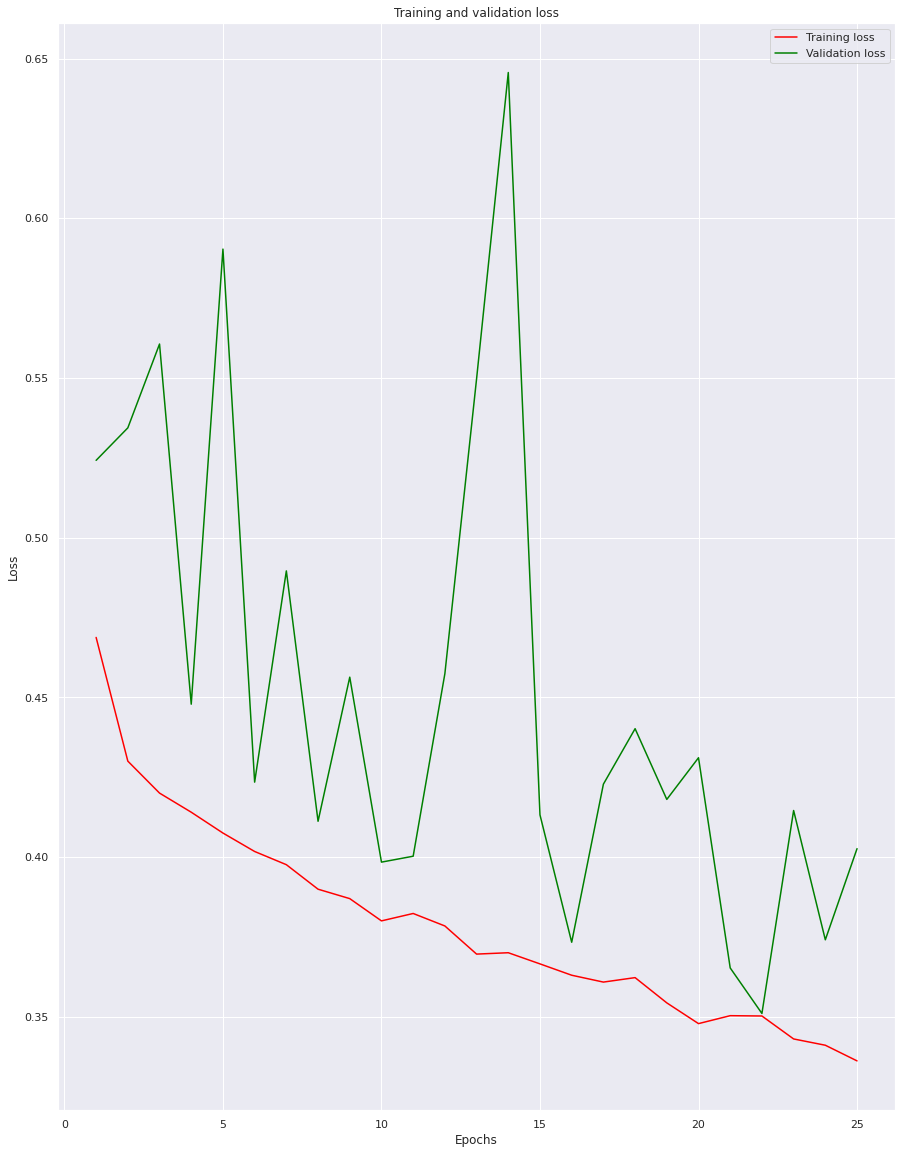

In [26]:
print_loss_history(M1_history, modelname, expno)

#Metric Time!!
For this project, there are seven labels which may be applied to any given image, with the only constraint being that the last one (index 6 indicating 'Normal') cannot be set to one if any others are also set to one. The standard metrics are Accuracy, Precision, Recall, and F1 Score, each of which has it's strengths and weaknesses.  
TP: True Positive 
TN: True Negative
FP: False Positive
FN: False Negative
#Accuracy = (TP + TN)/(TP + TN + FP + FN)
#Precision = TP/(TP + FP)
#Recall = TP/(TP + FN)
#F1 = (2PR)/(P + R)
Generally, for a medical test looking for a disease-state (indices 0 - 5 inclusive in this case), False Negatives are considered to be much worse than False Positives, because a person is being given a clean bill of health when in reality they have the disease condition, as such they are unlikely to get appropriate treatment as quickly.  Therefore *Recall* is generally more important than Accuracy or Precision for tests looking for a disease-state.  
In contrast, index 6 corresponds to a test for a healthy-state, so the roles are reversed: a False Positive means "clean bill of health when actually ill" and False Negative means "told one is ill when one is actually fine", therefore Precision is the more important metric.
Choosing an appropriate metric is complicated by the fact that there are six distinct disease states and only one healthy state, so a simple addition of the disease-state Recalls and the healthy-state Precision potentially ignores the case where a person has a disease but the algorithm isn't sure which.  This can be somewhat ameliorated by weighting Precision for healthy-state higher than the Recalls for the disease states, which is the approach taken here.  To really do this properly, one should consult with opthamologists to devise a single overall metric to judge by.

## Macro Metrics
We can get the macro-metrics directly from the Keras training history.  These are calculated using all seven states collectively, which means they aren't super useful beyond a simple "bigger is better" scheme.

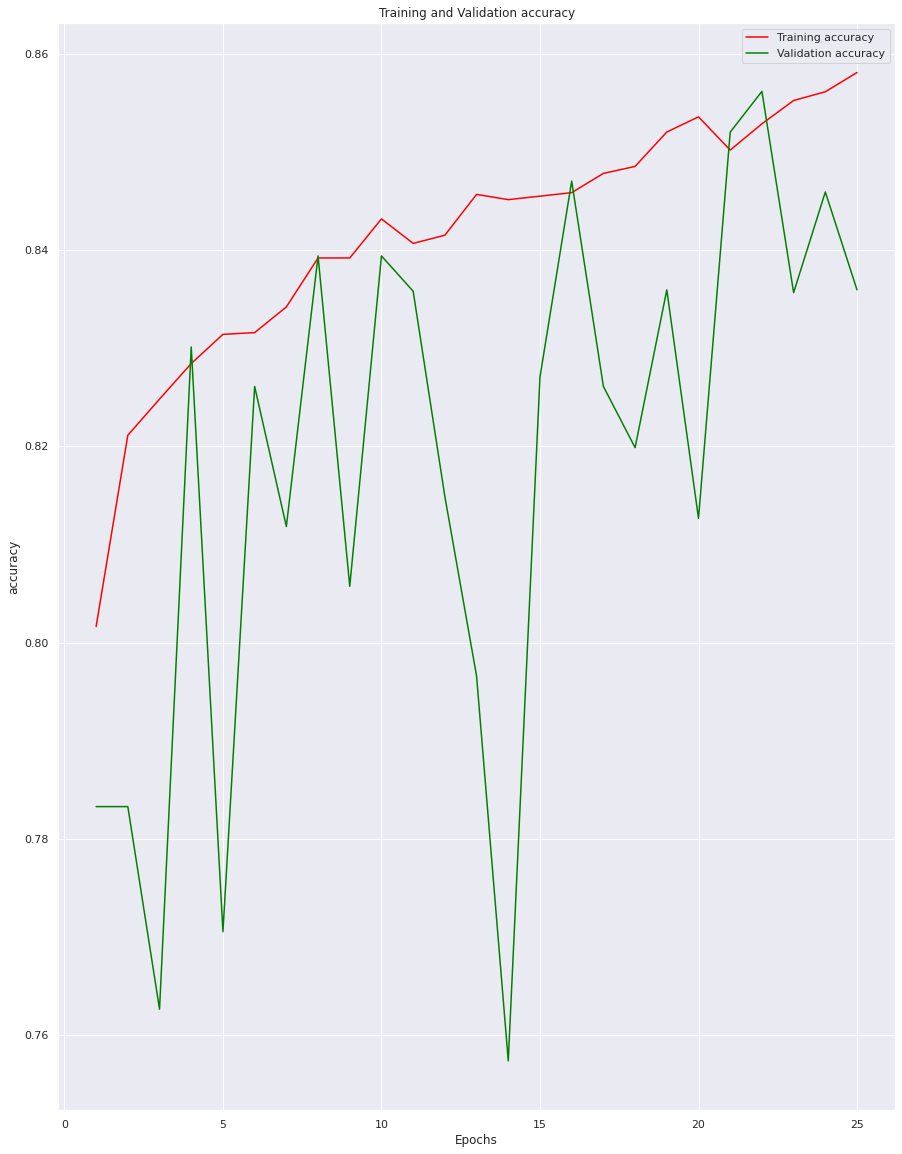

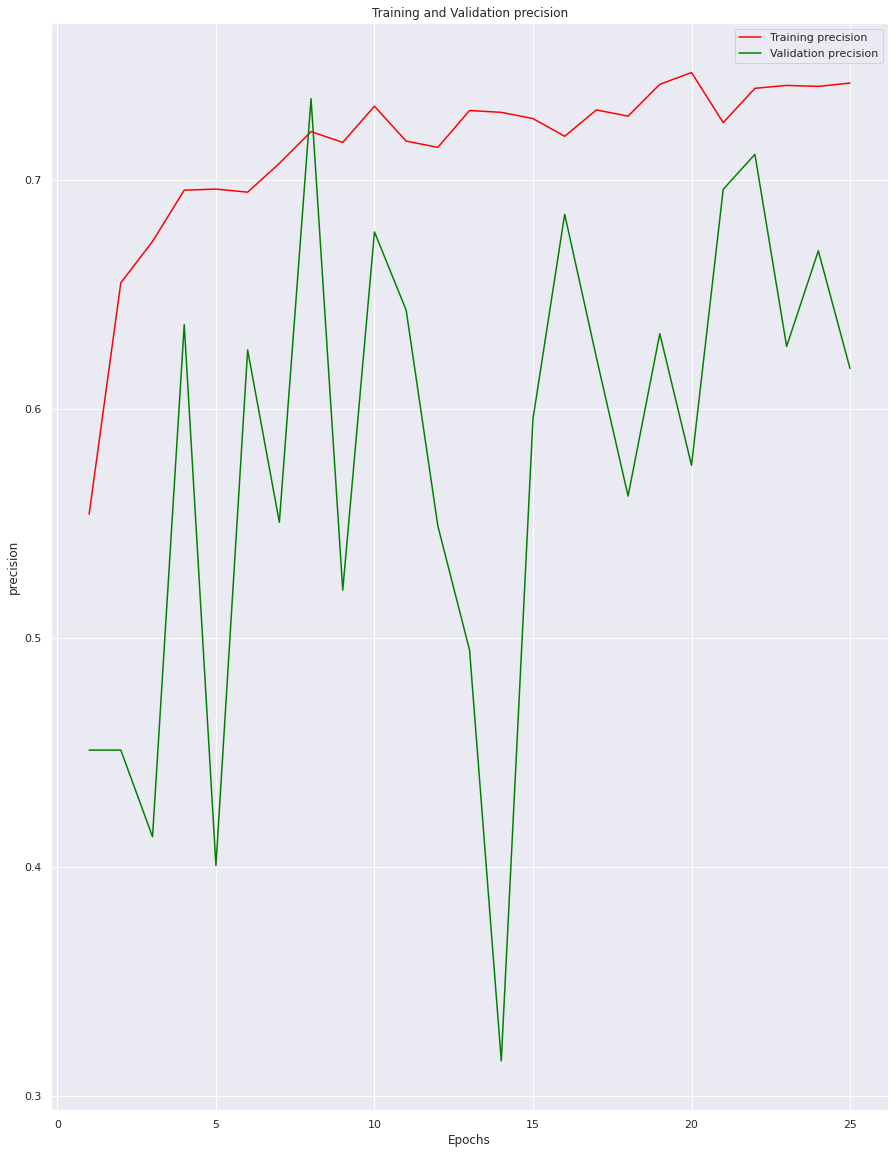

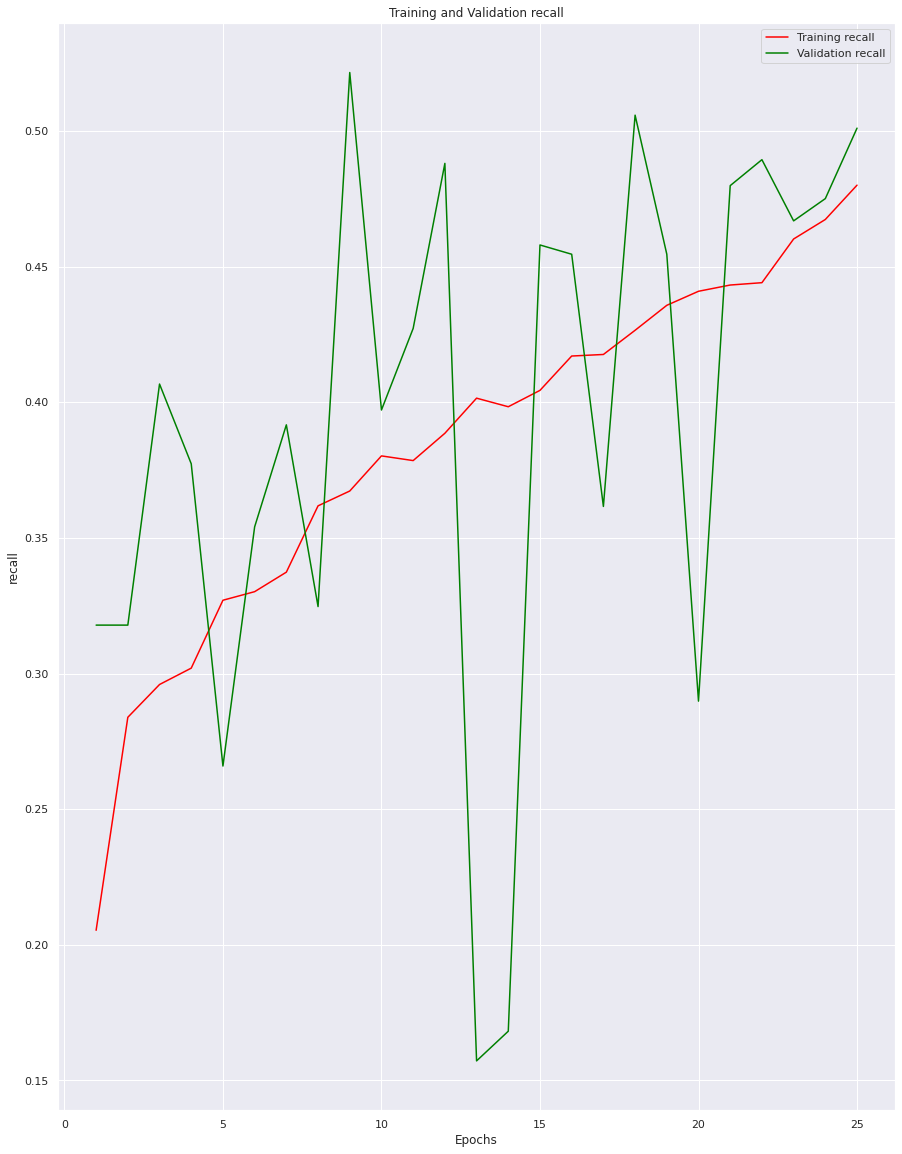

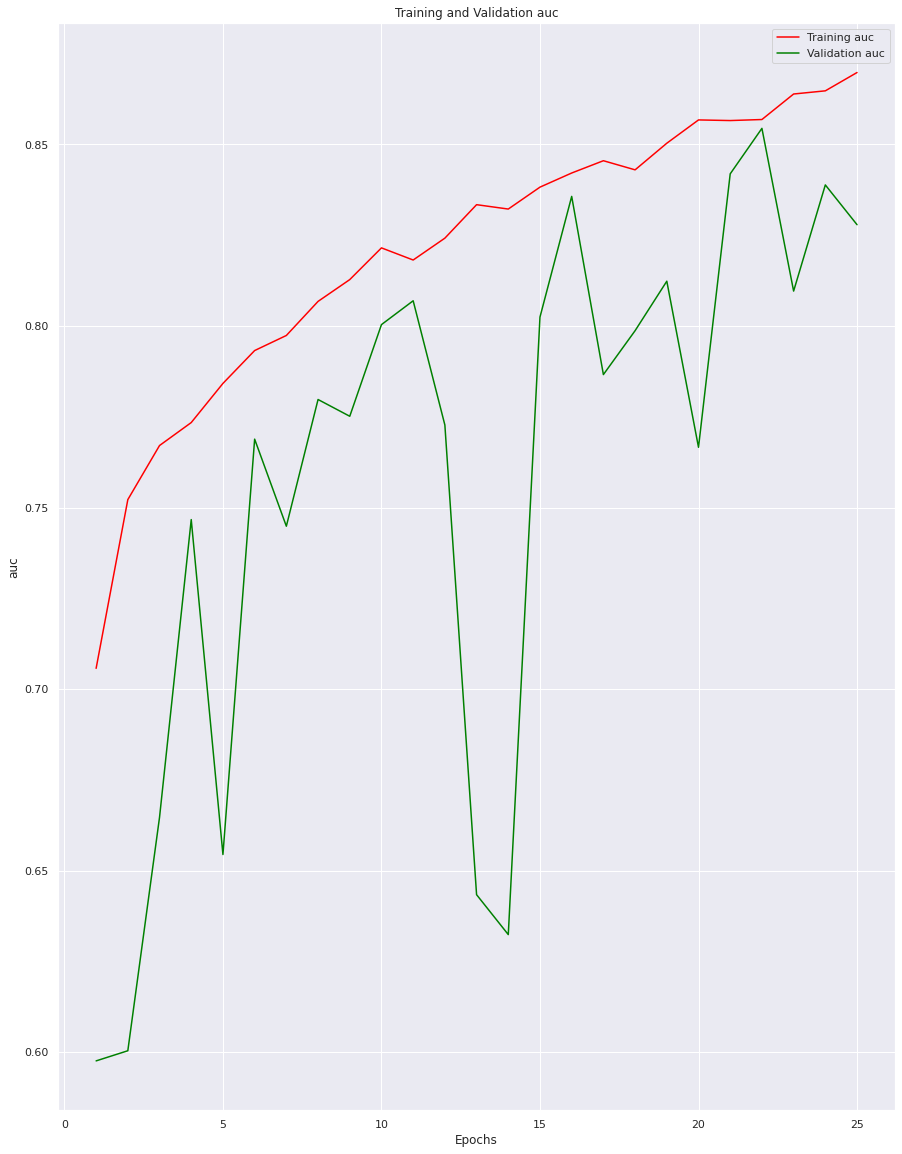

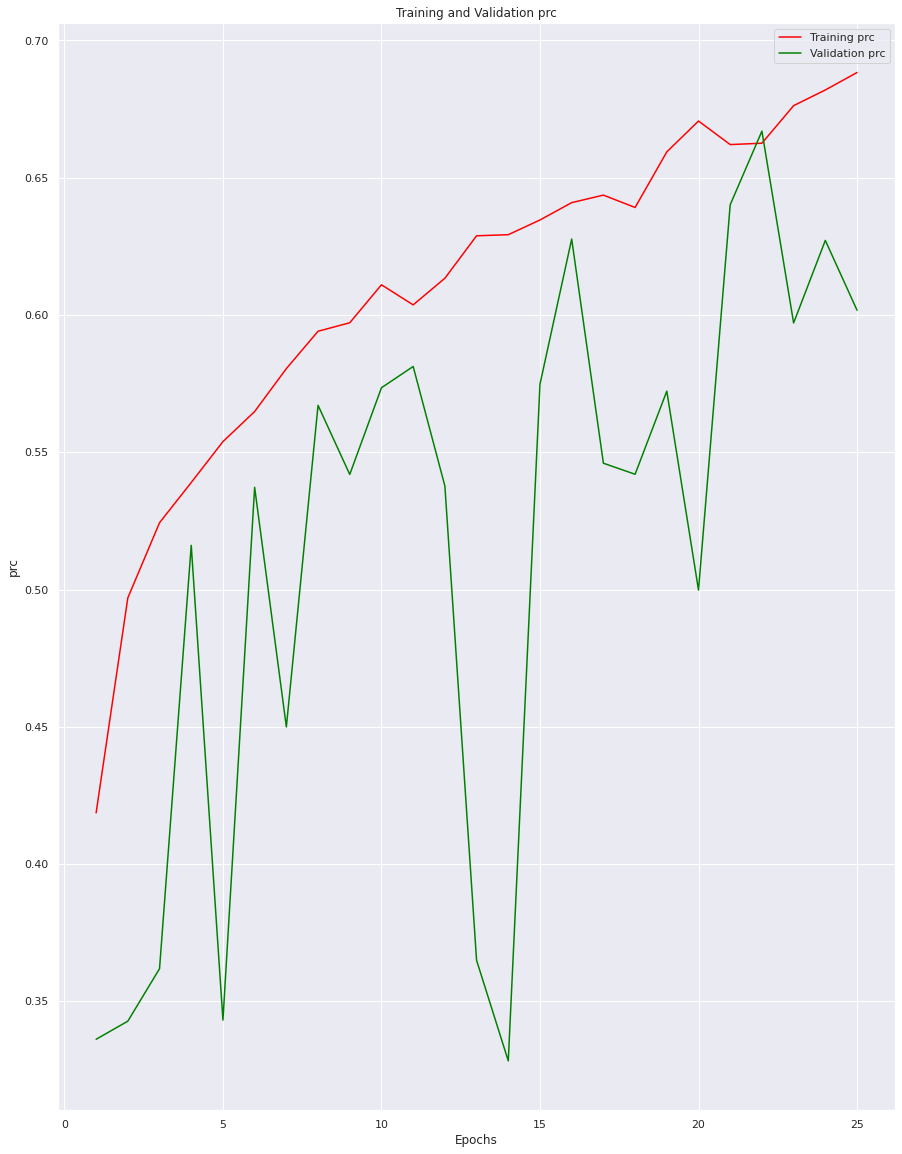

In [27]:
#mets = ['tp', 'fp', 'tn', 'fn']
mets = ['accuracy', 'precision', 'recall', 'auc', 'prc']
print_training_history(M1_history, mets, modelname, expno)

## Micro Metrics
This is what we are actually concerned with, the ability of the model to effectively classify each individual ailment or to declare the patient ailment-free.

In [28]:
#Create the multi-label confusion matrix
M_predictions = Model_One.predict(X_val)
M_predictions_hard = np.round_(M_predictions)

M_MLCM = MLCM(y_val, M_predictions_hard)

We will now compute all of the usual metrics for each disease-state and the healthy-state, even though at the moment only a few will be used.

In [29]:
#Recall the index ordering: 0 - Opacity, 1 - Diabetic Retinopathy, 2 - Glaucoma, 3 - Macular Edema,
# 4 - Macular Degeneration,  5 - Retinal Vascular Occlusion, 6 - Normal

index_map = {0: 'Opacity', 1: 'Diabetic Retinopathy', 2: 'Glaucoma', 3: 'Macular Edema', 4: 'Macular Degeneration', 
             5: 'Retinal Vascular Occlusion', 6: 'Normal'}

overall_score = 0 #A perfect score, indicating perfect Recall on all disease states and perfect Precision for the healthy state, would be 12
metrics = {}

for i, cm in enumerate(M_MLCM):
    if i < 6:
        overall_score += recall_from_CM(cm)
    else:
        overall_score += 6 * precision_from_CM(cm)
    print('|---------------- %s -------------------|' % index_map[i])
    acc = accuracy_from_CM(cm)
    prec = precision_from_CM(cm)
    recall = recall_from_CM(cm)
    F1 = F1_from_CM(cm)
    submet = {}
    submet['Accuracy'] = acc
    submet['Precision'] = prec
    submet['Recall'] = recall
    submet['F1_score'] = F1
    metrics[index_map[i]] = submet
    print(f'Accuracy: {acc}')
    print(f'Precision: {prec}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {F1}')

print('+++++++++++++++++++++++++++++++++++++')
print('Overall score: ', overall_score)

|---------------- Opacity -------------------|
Accuracy: 0.7681862269641125
Precision: 0.7215686274509804
Recall: 0.7913978494623656
F1 Score: 0.7548717948717948
|---------------- Diabetic Retinopathy -------------------|
Accuracy: 0.7526673132880698
Precision: 0.4584837545126354
Recall: 0.5474137931034483
F1 Score: 0.4990176817288802
|---------------- Glaucoma -------------------|
Accuracy: 0.8341416100872939
Precision: 0.5227272727272727
Recall: 0.5139664804469274
F1 Score: 0.5183098591549297
|---------------- Macular Edema -------------------|
Accuracy: 0.8506304558680893
Precision: 0.3148148148148148
Recall: 0.12686567164179105
F1 Score: 0.18085106382978727
|---------------- Macular Degeneration -------------------|
Accuracy: 0.8322017458777885
Precision: 0.9
Recall: 0.049723756906077346
F1 Score: 0.09424083769633508
|---------------- Retinal Vascular Occlusion -------------------|
Accuracy: 0.8874878758486906
Precision: 0
Recall: 0
F1 Score: 0
|---------------- Normal ------------

In [30]:
#Summary data, goes in JSON file for experiment tracking
expdata = {'Exp. No. ': expno, 'Model Name': modelname, 'Model Location': savelocation,'Hyperparameters': hypers, 
           'Training Time': delta_time, 'Metrics': metrics}
write_json(expdata)

updating JSON file


In [31]:
Model_One.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, None, None, 64)    9472      
                                                                 
 batch_normalization (BatchN  (None, None, None, 64)   256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, None, None, 64)    0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, None, None, 64)   0         
 )                                                               
                                                                 
 general_resnet_block (Gener  (None, None, None, 64)   223104    
 alResnetBlock)                                                  
                                                        

In [ ]:
# Use a list comprehension to extract the output of each layer in the model
layer_outputs = [layer.output for layer in Model_One.layers]
# Define a new model with the same input shape as the original model 
# and layer_outputs as its outputs
activation_model = Model(inputs=Model_One.inputs, outputs=layer_outputs)
# Get all the activations by calling the predict() method on the number 10 image 
# in X_train. Make sure to reshape the image so it has a new 0 axis of length 1.
activations_DR = activation_model.predict(X_train[23].reshape(1,224,224,3))

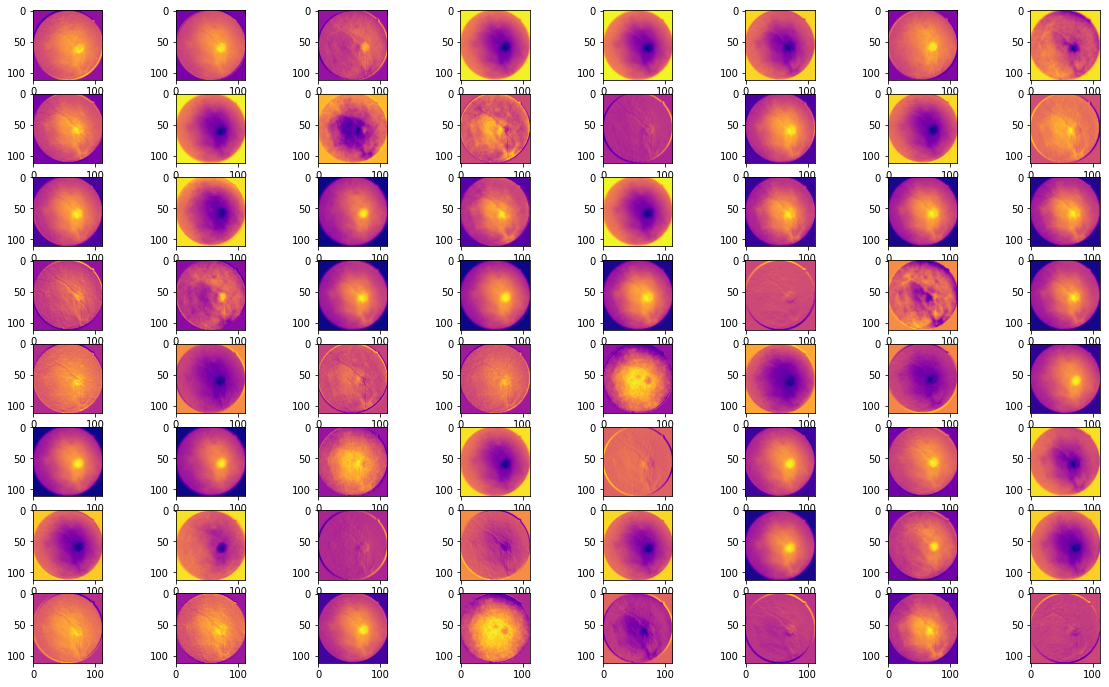

In [ ]:
#Alright, now let's have a look. 
display_activation(activations=activations_DR, col_size=8, row_size=8, act_index=1)

Let's make use of the grad-CAM functions found here: https://keras.io/examples/vision/grad_cam/

These will allow us to visualize the output of the last convolutional layer of the model & possibly overlay it on the original image.

In [ ]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 224x224
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (224, 224, 3)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 224, 224, 3)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
#import matplotlib.cm as colormap
def save_and_display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    #img = keras.preprocessing.image.load_img(img_path)
    #img = keras.preprocessing.image.img_to_array(img)
    # Rescale image to a range 0 - 255
    img = np.uint(255 * img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = colormap.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    #display(Image(cam_path))


We must identify images in the training set for each category in isolation.  We know from before that all categories appear many times, but we only need the one example for each, no need to get carried away.

In [ ]:
#Opacity only                    --> (1,0,0,0,0,0,0)
#Diabetic Retinopathy only       --> (0,1,0,0,0,0,0)
#Glaucoma only                   --> (0,0,1,0,0,0,0)
#Macular Edema only              --> (0,0,0,1,0,0,0)
#Macular Degeneration only       --> (0,0,0,0,1,0,0)
#Retinal Vascular Occlusion only --> (0,0,0,0,0,1,0)
#Normal                          --> (0,0,0,0,0,0,1)

Opacity_indices = [idx for idx,label in enumerate(y_train) if np.all(label == [1,0,0,0,0,0,0])]
DR_indices      = [idx for idx,label in enumerate(y_train) if np.all(label == [0,1,0,0,0,0,0])]
Glauc_indices   = [idx for idx,label in enumerate(y_train) if np.all(label == [0,0,1,0,0,0,0])]
MacEd_indices   = [idx for idx,label in enumerate(y_train) if np.all(label == [0,0,0,1,0,0,0])]
MacDeg_indices  = [idx for idx,label in enumerate(y_train) if np.all(label == [0,0,0,0,1,0,0])]
RVO_indices     = [idx for idx,label in enumerate(y_train) if np.all(label == [0,0,0,0,0,1,0])]
Normal_indices  = [idx for idx,label in enumerate(y_train) if np.all(label == [0,0,0,0,0,0,1])]

Opacity_idx = Opacity_indices[0]
DR_idx      = DR_indices[0]
Glauc_idx   = Glauc_indices[0]
MacEd_idx   = MacEd_indices[0]
MacDeg_idx  = MacDeg_indices[0]
RVO_idx     = RVO_indices[0]
Normal_idx  = Normal_indices[0]

In [ ]:
#Generify the content of the next few cells
last_conv_name = 'general_resnet_block_27'

names = ['Opacity', 'DiabeticRetinopathy', 'Glaucoma', 'MacularEdema', 'MacularDegeneration', 'RetinalVascularOcclusion', 'Normal']
indices = [Opacity_idx, DR_idx, Glauc_idx, MacEd_idx, MacDeg_idx, RVO_idx, Normal_idx]
images = [X_train[idx] for idx in indices]
img_arrays = [np.expand_dims(image, axis=0) for image in images]
heatmaps = [make_gradcam_heatmap(img_array, Model_One, last_conv_name) for img_array in img_arrays]

In [ ]:
for image,heatmap,name in zip(images, heatmaps, names):
    save_and_display_gradcam(image, heatmap, f'{MAIN_DIR}/{name}_overlay_expnum_{expno}.jpg')

## Barrier cell
Probably don't need the next few, I believe the two above completely cover them.